In [29]:
import os
import nltk
import math
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Embedding, Dropout, BatchNormalization, Input, Add, Concatenate,\
    Bidirectional, SimpleRNN, LSTM, GRU, TimeDistributed
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer


stopwords = set(stopwords.words("english"))
ps = PorterStemmer()

## Data Loader

In [30]:
df = pd.read_csv("../input/quora-crawler/data.csv")

### Feature Extractor

In [31]:
def tokenize(text):
    """
    :param text: a doc with multiple sentences, type: str
    return a word list, type: list
    e.g.
    Input: 'Text mining is to identify useful information.'
    Output: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    """
    return nltk.word_tokenize(text)

In [32]:
def stem(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of stemmed words, type: list
    e.g.
    Input: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    Output: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    """
    return [ps.stem(token) for token in tokens]

In [33]:
def filter_stopwords(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of filtered tokens, type: list
    e.g.
    Input: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    Output: ['text', 'mine', 'identifi', 'use', 'inform', '.']
    """
    return [token for token in tokens if token not in stopwords and not token.isnumeric()]

In [34]:
def get_index_vector(text, vocab_dict, max_len):
    # initialize the vector as all zeros
    vector = np.zeros(max_len, dtype=np.int64)
    for i, word in enumerate(text):
        if i == max_len:
            break
        # get the feature index, return 1 (<unk>) if the feature is not existed
        word_idx = vocab_dict.get(word, 1)
        vector[i] = word_idx
    return vector   

In [35]:
train_texts,val_texts,train_labels,val_labels = train_test_split(df.Text, df.Label, test_size=0.33, random_state=42)

# tokenization
train_tokens = [tokenize(text) for text in train_texts] 
val_tokens = [tokenize(text) for text in val_texts]

# stemming
train_stemmed = [stem(tokens) for tokens in train_tokens]
val_stemmed = [stem(tokens) for tokens in val_tokens]

# remove stopwords
# the input should be the stemmed tokens and the output is a cleanner token list
train_stemmed = [filter_stopwords(tokens) for tokens in train_stemmed]
val_stemmed = [filter_stopwords(tokens) for tokens in val_stemmed]

## Build vocabulary

In [36]:
vocab_dict = {'_unk_': 0, '_w_pad_': 1}
for doc in train_stemmed:
    for word in doc:
        if(word not in vocab_dict):
            vocab_dict[word] = len(vocab_dict)
            
for doc in val_stemmed:
    for word in doc:
        if(word not in vocab_dict):
            vocab_dict[word] = len(vocab_dict)
            
word2idx = vocab_dict
idx2word = {v:k for k,v in word2idx.items()}
print("size of word vocab:", len(vocab_dict))

size of word vocab: 30052


In [37]:
max_len = 1000

# build the vocal_matrix
# convert each example to a index vector, and then stack vectors as a matrix
train_matrix = np.vstack(
    [get_index_vector(text, vocab_dict, max_len) for text in train_stemmed])
val_matrix = np.vstack(
    [get_index_vector(text, vocab_dict, max_len) for text in val_stemmed])

# convert labels to label_matrix
num_classes = max(df.Label)+1
# convert each label to a ont-hot vector, and then stack vectors as a matrix
train_label_matrix = keras.utils.to_categorical(train_labels, num_classes=num_classes)
val_label_matrix = keras.utils.to_categorical(val_labels, num_classes=num_classes)

## Build RNN Model

In [38]:
def build_RNN(input_length, vocab_size, embedding_size,
              hidden_size, output_size,
              num_rnn_layers, num_mlp_layers,
              rnn_type="lstm",
              bidirectional=False,
              activation="tanh",
              dropout_rate=0.0,
              batch_norm=False,
              l2_reg=0.0,
              loss="categorical_crossentropy",
              optimizer="Adam",
              learning_rate=0.001,
              metric="accuracy"):
    
    x = Input(shape=(input_length,))
    
    ################################
    ###### Word Representation #####
    ################################
    # word representation layer
    emb = Embedding(input_dim=vocab_size,
                    output_dim=embedding_size,
                    input_length=input_length,
                    embeddings_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=0))(x)
    
    ################################
    ####### Recurrent Layers #######
    ################################
    # recurrent layers
    # Referennce: https://keras.io/api/layers/#recurrent-layers
    if rnn_type == "rnn":
        fn = SimpleRNN
    elif rnn_type == "lstm":
        fn = LSTM
    elif rnn_type == "gru":
        fn = GRU
    else:
        raise NotImplementedError
        
    h = emb
    for i in range(num_rnn_layers):
        is_last = (i == num_rnn_layers-1)
        if bidirectional:
            h = Bidirectional(fn(hidden_size,
                   kernel_initializer=keras.initializers.glorot_uniform(seed=0),
                   recurrent_initializer=keras.initializers.Orthogonal(gain=1.0, seed=0),
                   return_sequences=not is_last))(h)
            # return_sequences:
            # Boolean. Whether to return the last output. in the output sequence, or the full sequence.
            # [h_1, h_2, ..., h_n] or h_n
        else:
            h = fn(hidden_size,
                   kernel_initializer=keras.initializers.glorot_uniform(seed=0),
                   recurrent_initializer=keras.initializers.Orthogonal(gain=1.0, seed=0),
                   return_sequences=not is_last)(h)
        h = Dropout(dropout_rate, seed=0)(h)
    
    ################################
    #### Fully Connected Layers ####
    ################################
    # multi-layer perceptron
    for i in range(num_mlp_layers-1):
        new_h = Dense(hidden_size,
                      kernel_initializer=keras.initializers.he_normal(seed=0),
                      bias_initializer="zeros",
                      kernel_regularizer=keras.regularizers.l2(l2_reg))(h)
        # add batch normalization layer
        if batch_norm:
            new_h = BatchNormalization()(new_h)
        # add residual connection
        if i == 0:
            h = new_h
        else:
            h = Add()([h, new_h])
        # add activation
        h = Activation(activation)(h)
    y = Dense(output_size,
              activation="softmax",
              kernel_initializer=keras.initializers.he_normal(seed=0),
              bias_initializer="zeros")(h)
    
    # set the loss, the optimizer, and the metric
    if optimizer == "SGD":
        optimizer = keras.optimizers.SGD(lr=learning_rate)
    elif optimizer == "RMSprop":
        optmizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == "Adam":
        optmizer = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        raise NotImplementedError
    model = Model(x, y)
    model.compile(loss=loss, optimizer=optimizer, metrics=[metric])
    
    return model

In [39]:
embedding_size = 50
hidden_size = 100 
num_rnn_layers = 1
num_mlp_layers = 1
os.makedirs("models", exist_ok=True)
model = build_RNN(max_len, len(vocab_dict), embedding_size,
              hidden_size, num_classes,
              num_rnn_layers, num_mlp_layers,
              rnn_type="lstm",
              bidirectional=True,
              activation="tanh",
              dropout_rate=0.0,
              batch_norm=False,
              l2_reg=0.0,
              loss="categorical_crossentropy",
              optimizer="Adam",
              learning_rate=0.001,
              metric="accuracy")

checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)
earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=0)

np.random.seed(0)
tf.random.set_seed(0)
rnn_history = model.fit(train_matrix, train_label_matrix,
                    validation_split=0.1,
                    epochs=20, batch_size=100, verbose=1)
                    #callbacks=[checkpointer, earlystopping]
                      # )
model = keras.models.load_model(os.path.join("models", "weights.hdf5"))

Epoch 1/20
101/101 [==============================] - 17s 146ms/step - loss: 1.5391 - accuracy: 0.2907 - val_loss: 1.2109 - val_accuracy: 0.4403
Epoch 2/20
101/101 [==============================] - 14s 139ms/step - loss: 1.0943 - accuracy: 0.5314 - val_loss: 0.9679 - val_accuracy: 0.6280
Epoch 3/20
101/101 [==============================] - 14s 139ms/step - loss: 0.8075 - accuracy: 0.6870 - val_loss: 0.8559 - val_accuracy: 0.6792
Epoch 4/20
101/101 [==============================] - 14s 139ms/step - loss: 0.6104 - accuracy: 0.7852 - val_loss: 0.9230 - val_accuracy: 0.6774
Epoch 5/20
101/101 [==============================] - 14s 139ms/step - loss: 0.4831 - accuracy: 0.8367 - val_loss: 0.8949 - val_accuracy: 0.6846
Epoch 6/20
101/101 [==============================] - 14s 139ms/step - loss: 0.4205 - accuracy: 0.8534 - val_loss: 0.8592 - val_accuracy: 0.7143
Epoch 7/20
101/101 [==============================] - 14s 140ms/step - loss: 0.3489 - accuracy: 0.8785 - val_loss: 0.8236 - val_ac

## Evaluation

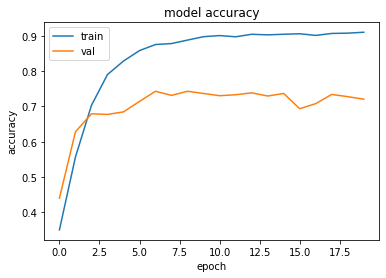

In [40]:
plt.plot(rnn_history.history['accuracy'])
plt.plot(rnn_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

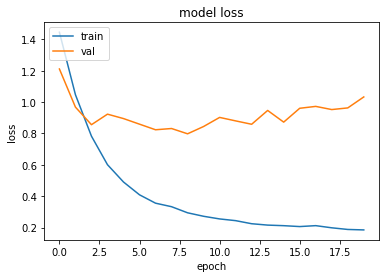

In [41]:
plt.plot(rnn_history.history['loss'])
plt.plot(rnn_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()